# EWX Forecasting Walkthrough

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import json
import math
from collections import deque
import EWX_forecast as ewx
import pprint
import os

csv = 'C:\\Users\\wb5888\\LA-tools\\EWX_Forecast\\csv'

## Chose file to upload

In [2]:
files = ewx.sortdir(csv, 10)

files found in dir:  C:\Users\wb5888\LA-tools\EWX_Forecast\csv
                                            files                time
0                  NEPOOL_MECO_2629670017_SCA.csv 2019-07-22 15:35:42
1                  NEPOOL_MECO_2629670017_idr.csv 2019-07-22 15:31:10
2              NEPOOL_MECO_2629670017_ch3 (2).csv 2019-07-22 15:31:02
3                                   lakes_idr.csv 2019-07-22 13:47:42
4                  NEPOOL_MECO_2629670017_ch1.csv 2019-07-22 11:15:56
5                  NEPOOL_MECO_2629670017_ch3.csv 2019-07-22 11:13:37
6                                        4A657000 2019-07-22 11:10:53
7         NEPOOL_CLP_51595487000_641912009_ts.csv 2019-07-19 09:05:47
8     NEPOOL_CLP_51595487000_641912009_ts2019.csv 2019-07-19 09:04:28
9  NEPOOL_CLP_51595487000_641912009_timeshift.csv 2019-07-19 09:03:21


In [3]:
myfile = files.files[1]
print('working with {}'.format(myfile))

working with NEPOOL_MECO_2629670017_idr.csv


## Import & plot

In [4]:
idr = pd.read_csv(myfile)
print('read data from disk...')

idr.columns = ['t', 'v']
idr['v'] = pd.to_numeric(idr['v'], errors = 'coerce')
idr.t = pd.to_datetime(idr.t, errors = 'coerce')
idr.set_index(pd.DatetimeIndex(idr.t), inplace = True, drop = True)

idr = idr.drop('t', axis = 1)
idr.dropna(inplace = True, axis = 0)
print('type conversions done...')

print('data loaded. ')
print('')
idr.head()

read data from disk...
type conversions done...
data loaded. 



,v
t,
2018-01-08 00:00:00,128.145916
2018-01-08 01:00:00,125.897742
2018-01-08 02:00:00,126.294478
2018-01-08 03:00:00,129.203880
2018-01-08 04:00:00,128.674898


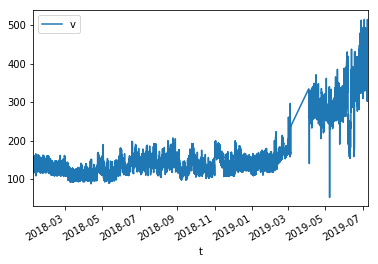

In [5]:
idr.plot(y = 'v')

# Default IDR Config

## Periodic Zeros
1. threshold (less than this is considered zero) 
2. periodicity percent (percent of time weekdays have to be zero to be nonperiodic)

In [6]:
#check for nonperiodic zeros
tmp2 = ewx.periodic_zero(idr, .01, 1)
tmp2.head()

,v,d,h,pz,lr
t,,,,,
2018-01-08 00:00:00,128.145916,0,0,0.0,False
2018-01-08 01:00:00,125.897742,0,1,0.0,False
2018-01-08 02:00:00,126.294478,0,2,0.0,False
2018-01-08 03:00:00,129.203880,0,3,0.0,False
2018-01-08 04:00:00,128.674898,0,4,0.0,False


## DST Check, Fix Nonhourly Intervals, Flag NA
1. missing hour in March window or extra in Nov window - cleans
2. adjusts nonhourly data
3. flags values that were initially missing

In [7]:
tmp2 = ewx.fix_interval(tmp2)
tmp2.head()

TypeError: zip argument #5 must support iteration

## Variance Validation
1. time window to calculate rolling statistics
2. should window be centered
3. number of standard deviations used to flag spikes & dips

In [8]:
#check spikes & dips
#time_window = int(60*24*3600/hb)
time_window = int(30*24)
centered = True
n_sd = 1

tmp2 = ewx.variance_validation(tmp2, time_window, centered, 2)
tmp2.head()

,v,d,h,pz,lr,min,y,mon,rm,mc,crm,crsd,var,spike,dip
t,,,,,,,,,,,,,,,
2018-01-08 00:00:00,128.145916,8,0,0.0,False,0,2018,1,132.864142,-4.718226,-0.050004,12.994637,93.357776,False,False
2018-01-08 01:00:00,125.897742,8,1,0.0,False,0,2018,1,132.823231,-6.925489,-0.088958,12.997666,76.851191,False,False
2018-01-08 02:00:00,126.294478,8,2,0.0,False,0,2018,1,132.781815,-6.487337,-0.128364,13.001288,49.538439,False,False
2018-01-08 03:00:00,129.203880,8,3,0.0,False,0,2018,1,132.738442,-3.534562,-0.169684,13.007163,19.830274,False,False
2018-01-08 04:00:00,128.674898,8,4,0.0,False,0,2018,1,132.699304,-4.024406,-0.206718,13.008438,18.468080,False,False


# Flag Errors

In [9]:
data_filter = [a or b or c for a, b, c in zip(tmp2.lr, tmp2.spike, tmp2.dip)]
tmp2['err'] = data_filter
tmp2.head()

,v,d,h,pz,lr,min,y,mon,rm,mc,crm,crsd,var,spike,dip,err
t,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,128.145916,8,0,0.0,False,0,2018,1,132.864142,-4.718226,-0.050004,12.994637,93.357776,False,False,False
2018-01-08 01:00:00,125.897742,8,1,0.0,False,0,2018,1,132.823231,-6.925489,-0.088958,12.997666,76.851191,False,False,False
2018-01-08 02:00:00,126.294478,8,2,0.0,False,0,2018,1,132.781815,-6.487337,-0.128364,13.001288,49.538439,False,False,False
2018-01-08 03:00:00,129.203880,8,3,0.0,False,0,2018,1,132.738442,-3.534562,-0.169684,13.007163,19.830274,False,False,False
2018-01-08 04:00:00,128.674898,8,4,0.0,False,0,2018,1,132.699304,-4.024406,-0.206718,13.008438,18.468080,False,False,False


# Interpolate Error Values

In [10]:
tmp2['interp'] = ewx.interp(tmp2.v, tmp2.err)
    
linear = tmp2.interp.interpolate(method = 'linear', axis = 0, in_place = False, limit_direction = 'forward')
tmp2['lin'] = linear
tmp2.lin[tmp2.lin.isnull()] = tmp2.v[tmp2.lin.isnull()]
tmp2.head()

c:\users\wb5888\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,v,d,h,pz,lr,min,y,mon,rm,mc,crm,crsd,var,spike,dip,err,interp,lin
t,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,128.145916,8,0,0.0,False,0,2018,1,132.864142,-4.718226,-0.050004,12.994637,93.357776,False,False,False,128.145916,128.145916
2018-01-08 01:00:00,125.897742,8,1,0.0,False,0,2018,1,132.823231,-6.925489,-0.088958,12.997666,76.851191,False,False,False,125.897742,125.897742
2018-01-08 02:00:00,126.294478,8,2,0.0,False,0,2018,1,132.781815,-6.487337,-0.128364,13.001288,49.538439,False,False,False,126.294478,126.294478
2018-01-08 03:00:00,129.203880,8,3,0.0,False,0,2018,1,132.738442,-3.534562,-0.169684,13.007163,19.830274,False,False,False,129.203880,129.203880
2018-01-08 04:00:00,128.674898,8,4,0.0,False,0,2018,1,132.699304,-4.024406,-0.206718,13.008438,18.468080,False,False,False,128.674898,128.674898


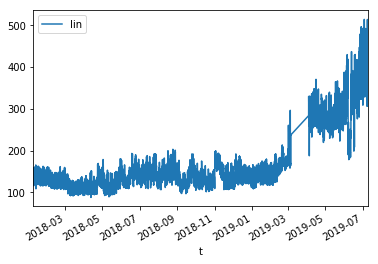

In [11]:
tmp2.plot(y = 'lin')

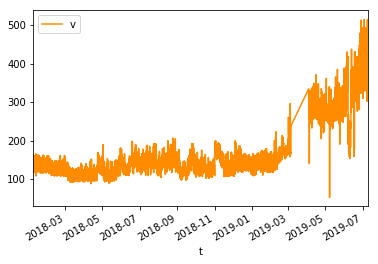

In [12]:
tmp2.plot(y = 'v', color = 'darkorange')

# Scalar Compare

In [13]:
sca = pd.read_csv('NEPOOL_MECO_2629670017_SCA.csv', header = 0)
sca.head()

,Meter Id,Start Date,Stop Date,Usage,Demand,Avg Daily Usage,Load Factor
0,NEPOOL_MECO_2629670017,4/3/2019 0:00,5/2/2019 23:59,"197,400",387.0,"6,580",0.71
1,NEPOOL_MECO_2629670017,3/5/2019 0:00,4/2/2019 23:59,"130,500",396.0,"4,500",0.47
2,NEPOOL_MECO_2629670017,2/4/2019 0:00,3/4/2019 23:59,"115,800",324.0,"3,993.11",0.51
3,NEPOOL_MECO_2629670017,1/4/2019 0:00,2/3/2019 23:59,"104,100",197.1,"3,358.07",0.71
4,NEPOOL_MECO_2629670017,12/4/2018 0:00,1/3/2019 23:59,"104,000",189.0,"3,354.84",0.74


In [14]:
split = [u.split(',') for u in sca['Usage']]
merge = [''.join(a) for a in split]
sca['Usage'] = pd.to_numeric(merge)

split = [u.split(',') for u in sca['Avg Daily Usage']]
merge = [''.join(a) for a in split]
sca['Avg Daily Usage'] = pd.to_numeric(merge)

sca['Start Date'] = pd.to_datetime(sca['Start Date'], errors = 'coerce')
sca['Stop Date'] = pd.to_datetime(sca['Stop Date'], errors = 'coerce')
sca['Days'] = [math.ceil((a - b).total_seconds() / (3600*24)) for a, b in zip(sca['Stop Date'], sca['Start Date'])]

sca['Demand'] = pd.to_numeric(sca['Demand'], errors = 'coerce')
sca['Load Factor'] = pd.to_numeric(sca['Load Factor'], errors = 'coerce')

In [26]:
sca.head()

,Meter Id,Start Date,Stop Date,Usage,Demand,Avg Daily Usage,Load Factor,Days,y,mon
0,NEPOOL_MECO_2629670017,2019-04-03,2019-05-02 23:59:00,197400,387.0,6580.00,0.71,30,2019,4
1,NEPOOL_MECO_2629670017,2019-03-05,2019-04-02 23:59:00,130500,396.0,4500.00,0.47,29,2019,3
2,NEPOOL_MECO_2629670017,2019-02-04,2019-03-04 23:59:00,115800,324.0,3993.11,0.51,29,2019,2
3,NEPOOL_MECO_2629670017,2019-01-04,2019-02-03 23:59:00,104100,197.1,3358.07,0.71,31,2019,1
4,NEPOOL_MECO_2629670017,2018-12-04,2019-01-03 23:59:00,104000,189.0,3354.84,0.74,31,2018,12


In [16]:
sca['y'] = [a.year for a in sca['Start Date']]
sca['mon'] = [a.month for a in sca['Start Date']]

In [27]:
sca.head()

,Meter Id,Start Date,Stop Date,Usage,Demand,Avg Daily Usage,Load Factor,Days,y,mon
0,NEPOOL_MECO_2629670017,2019-04-03,2019-05-02 23:59:00,197400,387.0,6580.00,0.71,30,2019,4
1,NEPOOL_MECO_2629670017,2019-03-05,2019-04-02 23:59:00,130500,396.0,4500.00,0.47,29,2019,3
2,NEPOOL_MECO_2629670017,2019-02-04,2019-03-04 23:59:00,115800,324.0,3993.11,0.51,29,2019,2
3,NEPOOL_MECO_2629670017,2019-01-04,2019-02-03 23:59:00,104100,197.1,3358.07,0.71,31,2019,1
4,NEPOOL_MECO_2629670017,2018-12-04,2019-01-03 23:59:00,104000,189.0,3354.84,0.74,31,2018,12


## group IDR by (year, month, day, hour)

In [28]:
def monthly(data):
    data['month'] = list(zip(data['y'], data['mon']))
    monthly_sum = data.groupby(['month']).sum()
    monthly_sum = monthly_sum[['v']]
    return(monthly_sum)

## IDR monthly

In [22]:
idr = tmp2.copy()
print(idr.head())
print('')
print(idr.tail())

                              v  d  h   pz     lr  min     y  mon          rm  \
t                                                                               
2018-01-08 00:00:00  128.145916  8  0  0.0  False    0  2018    1  132.864142   
2018-01-08 01:00:00  125.897742  8  1  0.0  False    0  2018    1  132.823231   
2018-01-08 02:00:00  126.294478  8  2  0.0  False    0  2018    1  132.781815   
2018-01-08 03:00:00  129.203880  8  3  0.0  False    0  2018    1  132.738442   
2018-01-08 04:00:00  128.674898  8  4  0.0  False    0  2018    1  132.699304   

                           mc       crm       crsd        var  spike    dip  \
t                                                                             
2018-01-08 00:00:00 -4.718226 -0.050004  12.994637  93.357776  False  False   
2018-01-08 01:00:00 -6.925489 -0.088958  12.997666  76.851191  False  False   
2018-01-08 02:00:00 -6.487337 -0.128364  13.001288  49.538439  False  False   
2018-01-08 03:00:00 -3.534562 -0.1696

In [23]:
idr['date'] = list(zip(idr['y'], idr['mon'], idr['d'], idr['h']))
tmp = idr.groupby(['date']).sum()
tmp2 = tmp[['v', 'y', 'mon', 'd', 'h']]

mon_idr = monthly(tmp2)

c:\users\wb5888\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
print(mon_idr.head())
print('...')
print(mon_idr.tail())

                      v
month                  
(2018, 1)  76635.489401
(2018, 2)  84301.559623
(2018, 3)  81537.484521
(2018, 4)  83863.506372
(2018, 5)  91823.546645
...
                        v
month                    
(2019, 6)   230067.540000
(2019, 7)    79110.900000
(4036, 24)    5976.503226
(4038, 2)   207268.149233
(4038, 4)    26849.287208


## Scalar

In [52]:
mon_sca = sca.groupby(['mon']).sum()

In [53]:
mon_sca = mon_sca['Usage']

In [54]:
print(mon_sca.head())
print('...')
print(mon_sca.tail())

mon
1    273200
2    277200
3    293000
4    360800
5    182700
Name: Usage, dtype: int64
...
mon
8     312000
9     254500
10    257700
11    270200
12    282600
Name: Usage, dtype: int64


In [59]:
mon_idr = mon_idr[int(a in list(mon_sca.index)) for a in list(mon_idr.index)]
mon_idr.head()

SyntaxError: invalid syntax (<ipython-input-59-6a4c9c03c645>, line 1)

In [55]:
mon_sum = pd.concat([mon_idr, mon_sca], axis = 1)
mon_sum.columns = ['idr', 'sca']

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [49]:
print(mon_idr.index)
print('')
print(mon_sca.index)
print('')

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4, 5, 6, 7, 24, 2, 4], dtype='int64', name='m')

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='mon')



In [44]:
mon_idr['m'] = [a[1] for a in mon_idr.index]
mon_idr.reset_index(drop = True, inplace = True)
mon_idr.head()

,v,m
0,76635.489401,1
1,84301.559623,2
2,81537.484521,3
3,83863.506372,4
4,91823.546645,5


In [47]:
#mon_idr.set_index('m', drop = True, inplace = True)
print(mon_idr.head())
print('')
print(mon_idr.tail())

              v
m              
1  76635.489401
2  84301.559623
3  81537.484521
4  83863.506372
5  91823.546645

                v
m                
6   230067.540000
7    79110.900000
24    5976.503226
2   207268.149233
4    26849.287208


In [60]:
print(mon_sum.head())
print('...')
print(mon_sum.tail())

                    idr  sca
(2018, 1)  76635.489401  NaN
(2018, 2)  84301.559623  NaN
(2018, 3)  81537.484521  NaN
(2018, 4)  83863.506372  NaN
(2018, 5)  91823.546645  NaN
...
    idr       sca
8   NaN  312000.0
9   NaN  254500.0
10  NaN  257700.0
11  NaN  270200.0
12  NaN  282600.0


In [37]:
mon_sum.index

Index([ (2018, 1),  (2018, 2),  (2018, 3),  (2018, 4),  (2018, 5),  (2018, 6),
        (2018, 7),  (2018, 8),  (2018, 9), (2018, 10), (2018, 11), (2018, 12),
        (2019, 2),  (2019, 3),  (2019, 4),  (2019, 5),  (2019, 6),  (2019, 7),
       (4036, 24),  (4038, 2),  (4038, 4),          1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12],
      dtype='object')

# Monthly Sum

In [63]:
rec_mon = mon_sum.copy()
rec_mon['month'] = [a for a in rec_mon.index.to_series()]

In [68]:
for r in rec_mon['month']:
    if type(r) != 'int':
        try:
            rec_mon['month'] = r[1]
        except:
            rec_mon['month'] = int(r)
        finally:
            pass

In [69]:
rec_mon

,idr,sca,month
"(2018, 1)",76635.489401,NaN,4
"(2018, 2)",84301.559623,NaN,4
"(2018, 3)",81537.484521,NaN,4
"(2018, 4)",83863.506372,NaN,4
"(2018, 5)",91823.546645,NaN,4
"(2018, 6)",100959.108808,NaN,4
"(2018, 7)",107277.525781,NaN,4
"(2018, 8)",109331.681567,NaN,4
"(2018, 9)",94913.539926,NaN,4
"(2018, 10)",94556.557392,NaN,4


In [64]:
monthly = rec_mon.groupby(['month']).sum()
monthly['ratio'] = [b/a for a, b in zip(monthly['idr'], monthly['sca'])]

ratio = pd.DataFrame(monthly[['ratio']])
mu_ratio = np.mean(ratio.ratio[ratio.ratio > 1])

ratio.ratio[ratio.ratio < 1] = mu_ratio
ratio

TypeError: '<' not supported between instances of 'int' and 'tuple'

In [213]:
merge_idr = idr.merge(ratio, right_on = ['month'], how = 'left', left_on = ['mon'], right_index = True)
final_idr = merge_idr[['v', 'interp', 'ratio']]
final_idr['adj_interp'] = [a*b for a, b in zip(final_idr['interp'], final_idr['ratio'])]
final_idr['adj_v'] = [a*b for a, b in zip(final_idr['v'], final_idr['ratio'])]

c:\users\wb5888\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\wb5888\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [214]:
print(final_idr.head())
print('...')
print(final_idr.tail())

                              v      interp     ratio  adj_interp       adj_v
t                                                                            
2019-01-01 00:00:00  121.282233  121.282233  1.806189  219.058594  219.058594
2019-01-01 01:00:00  120.470981  120.470981  1.806189  217.593320  217.593320
2019-01-01 02:00:00  122.228695  122.228695  1.806189  220.768082  220.768082
2019-01-01 03:00:00  123.986408  123.986408  1.806189  223.942844  223.942844
2019-01-01 04:00:00  124.121617  124.121617  1.806189  224.187057  224.187057
...
                              v      interp     ratio  adj_interp       adj_v
t                                                                            
2019-12-31 19:00:00  129.259548  129.259548  1.009198  130.448445  130.448445
2019-12-31 20:00:00  128.042670  128.042670  1.009198  129.220375  129.220375
2019-12-31 21:00:00  127.637044  127.637044  1.009198  128.811018  128.811018
2019-12-31 22:00:00  126.149748  126.149748  1.009198  127.3

# Plot Adjusted Data

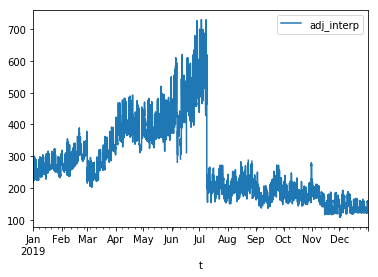

In [215]:
final_idr.plot(y = 'adj_interp')

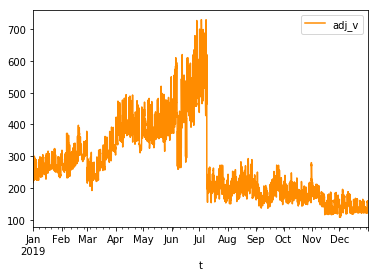

In [217]:
final_idr.plot(y = 'adj_v', color = 'darkorange')

In [271]:
mon_sum.reset_index(inplace = True)
mon_sum.columns = ['y', 'mon', 'idr', 'sca']

## Scalar Monthly

In [256]:
months = pd.DataFrame()
months['sca'] = mon_sum.groupby(['mon'])['sca'].mean()

## IDR Monthly

In [298]:
months['idr'] = mon_sum.groupby(['mon'])['idr'].mean()
months['rm'] = idr.groupby(['mon'])['rm'].mean()
months['diff'] = [abs(b - a)/3600 for a, b in zip(months['sca'], months['idr'])]
months['adj'] = months['rm'] + months['diff']

merge_idr = idr.merge(months['adj'], right_on = ['mon'], how = 'left', left_on = ['mon'], right_index = True)
merge_idr['final'] = [a + b for a, b in zip(merge_idr['lin'], merge_idr['adj'])]

In [299]:
merge_idr = pd.concat([merge_idr, final_idr['ratio']], axis = 1)
merge_idr['final_adj'] = [a*(b + c) for a, b, c in zip(merge_idr['ratio'], merge_idr['final'], merge_idr['adj'])]

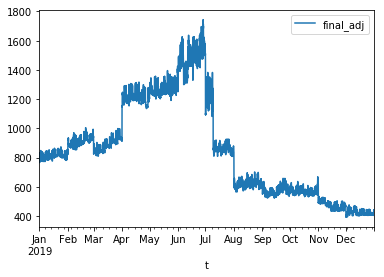

In [300]:
merge_idr.plot(y = 'final_adj')

# Write Validated Data

In [ ]:
#final validated data

print('writing validated data to .csv...')
final = tmp2.copy()
val = myfile.split('.')[0]
val_file = ''.join([val, '_val.csv'])
final.to_csv(val_file, header = True, index = True)
print('wrote {} to {}.'.format(val_file, os.getcwd()))

# Timeshift/Forecast
1. shift validated data *years* in the future

In [ ]:
forecast = ewx.timeshift(final, 10)
    
print('writing forecasts to .csv...')
name = myfile.split('.')[0]
ts_name = '_'.join([name, 'timeshift'])
ts_name = '.'.join([ts_name, 'csv'])
forecast.to_csv(ts_name, header = False)
print('wrote {} to {}.'.format(ts_name, os.getcwd()))
forecast.head()

In [ ]:
forecast.plot(y = 'v', color = 'darkorange')